# Operator-weighted pCN: GP Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from scipy.interpolate import interp1d
from scipy.optimize import minimize

import tinyDA as tda

In [2]:
np.random.seed(456)

### Defining the true model and generating some data

In [3]:
# define some function
def latent_function(x):
    return np.sin(2*np.pi*x)

In [4]:
# set the number of datapoints and the desired noise
n_data = 10
sigma = 0.1

# draw some random datapoints, evaluate the function and add noise.
x_data = np.random.uniform(size=n_data)
y_data = latent_function(x_data) + np.random.normal(0, sigma, size=x_data.shape[0])

# set the basis.
x = np.linspace(0,1)

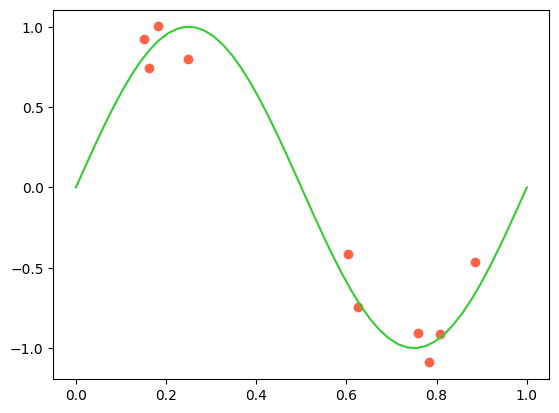

In [5]:
# plot the true function and the datapoints.
plt.plot(x, latent_function(x), c='limegreen')
plt.scatter(x_data, y_data, c='tomato')
plt.show()

### Set up the statistical model

In [6]:
# define the GP kernel (squared exponential)
def kernel(x, y, l):
    return np.exp(-0.5 * (x - y)**2 / l**2)

In [7]:
# set the length scale and the dimension of the basis.
l = 0.1
n_x = x.shape[0]

# construct the kernel matrix
K = np.zeros((n_x, n_x))
for i in range(n_x):
    for j in range(n_x):
        K[i,j] = kernel(x[i], x[j], l)

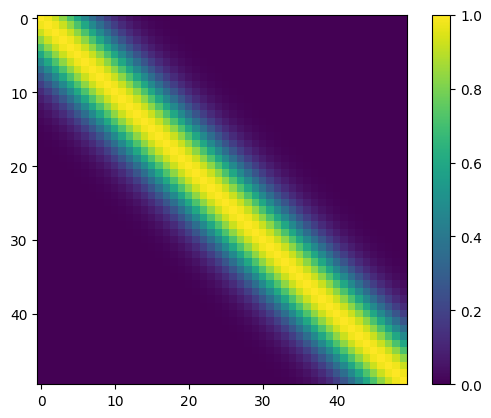

In [8]:
# plot the kernel matrix
plt.imshow(K)
plt.colorbar()
plt.show()

In [9]:
# set the GP prior
mean_prior = np.zeros(n_x)
my_prior = multivariate_normal(mean=mean_prior, cov=K+1e-3*np.eye(n_x))

# set the Gaussian likelihood
cov_likelihood = sigma**2*np.eye(n_data)
my_loglike = tda.GaussianLogLike(y_data, cov_likelihood)

In [10]:
# define a model.
def my_model(y):

    # interpolate the GP function
    f = interp1d(x, y)
    
    # evaluate at datapoints
    return f(x_data)

In [11]:
# initialise the Posterior
my_posterior = tda.Posterior(my_prior, my_loglike, my_model)

In [12]:
# get the MAP point using minimize, which also approximates the Hessian for free.
_MAP = minimize(lambda x: -my_posterior.create_link(x).posterior, x0=my_prior.rvs())
MAP = _MAP['x']
H_inv = _MAP.hess_inv

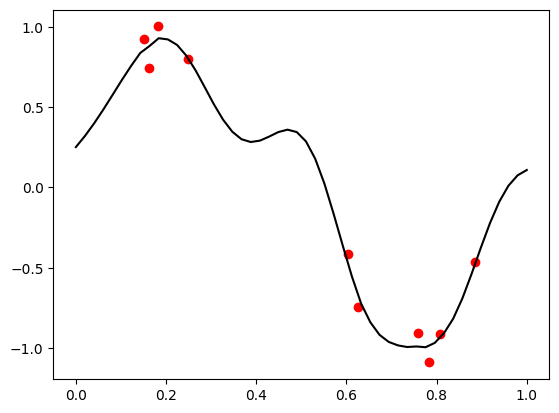

In [13]:
# plot the MAP estimate.
plt.plot(x, MAP, c='k')
plt.scatter(x_data, y_data, c='r')
plt.show()

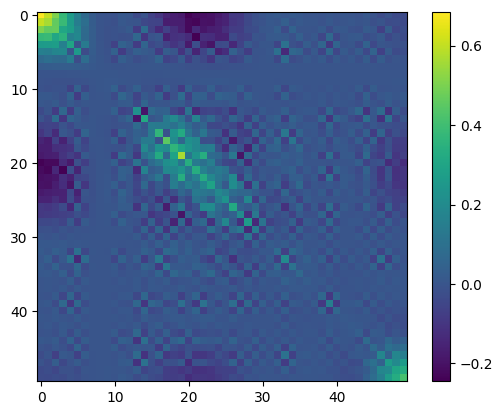

In [14]:
# plot the Hessian approximation.
plt.imshow(H_inv)
plt.colorbar()
plt.show()

### Set up the proposal

In [15]:
# preconditioned Crank-Nicolson
#pcn_adaptive = True
#my_proposal = tda.CrankNicolson(adaptive=pcn_adaptive)

# preconditioned Crank-Nicolson
pcn_operator = H_inv
pcn_adaptive = True
my_proposal = tda.OperatorWeightedCrankNicolson(pcn_operator, adaptive=pcn_adaptive)

### Sample

In [16]:
import os
if "CI" in os.environ:
    iterations = 120
    burnin = 20
else:
    iterations = 12000
    burnin = 2000

In [17]:
my_chains = tda.sample(my_posterior, my_proposal, iterations=iterations, n_chains=2, initial_parameters=MAP, force_sequential=True)

Sampling chain 1/2


Running chain, α = 0.05:   0%|          | 38/12000 [00:00<02:11, 91.11it/s]

Running chain, α = 0.31: 100%|██████████| 12000/12000 [01:28<00:00, 135.01it/s]


Sampling chain 2/2


Running chain, α = 0.19: 100%|██████████| 12000/12000 [01:34<00:00, 127.39it/s]


### Get some diagnostics

In [18]:
import arviz as az

In [19]:
idata = tda.to_inference_data(my_chains, burnin=burnin)

/home/louisekluge/miniconda3/envs/tda/lib/python3.12/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


In [20]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,0.201,0.955,-1.581,1.989,0.042,0.029,523.0,1696.0,1.02
x1,0.286,0.873,-1.290,1.971,0.025,0.018,1193.0,1942.0,1.00
x2,0.321,0.760,-1.023,1.762,0.020,0.014,1470.0,2120.0,1.00
x3,0.445,0.667,-0.715,1.806,0.087,0.062,58.0,405.0,1.03
x4,0.452,0.491,-0.462,1.376,0.016,0.011,963.0,1919.0,1.00
x5,0.530,0.347,-0.151,1.138,0.016,0.011,482.0,886.0,1.02
x6,0.637,0.223,0.204,1.042,0.034,0.024,44.0,688.0,1.05
x7,0.802,0.138,0.541,1.054,0.050,0.037,8.0,29.0,1.19
x8,0.904,0.092,0.731,1.069,0.042,0.033,5.0,16.0,1.33
x9,0.980,0.089,0.810,1.143,0.031,0.023,8.0,19.0,1.18


/home/louisekluge/miniconda3/envs/tda/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (50), generating only 20 plots
  warnings.warn(


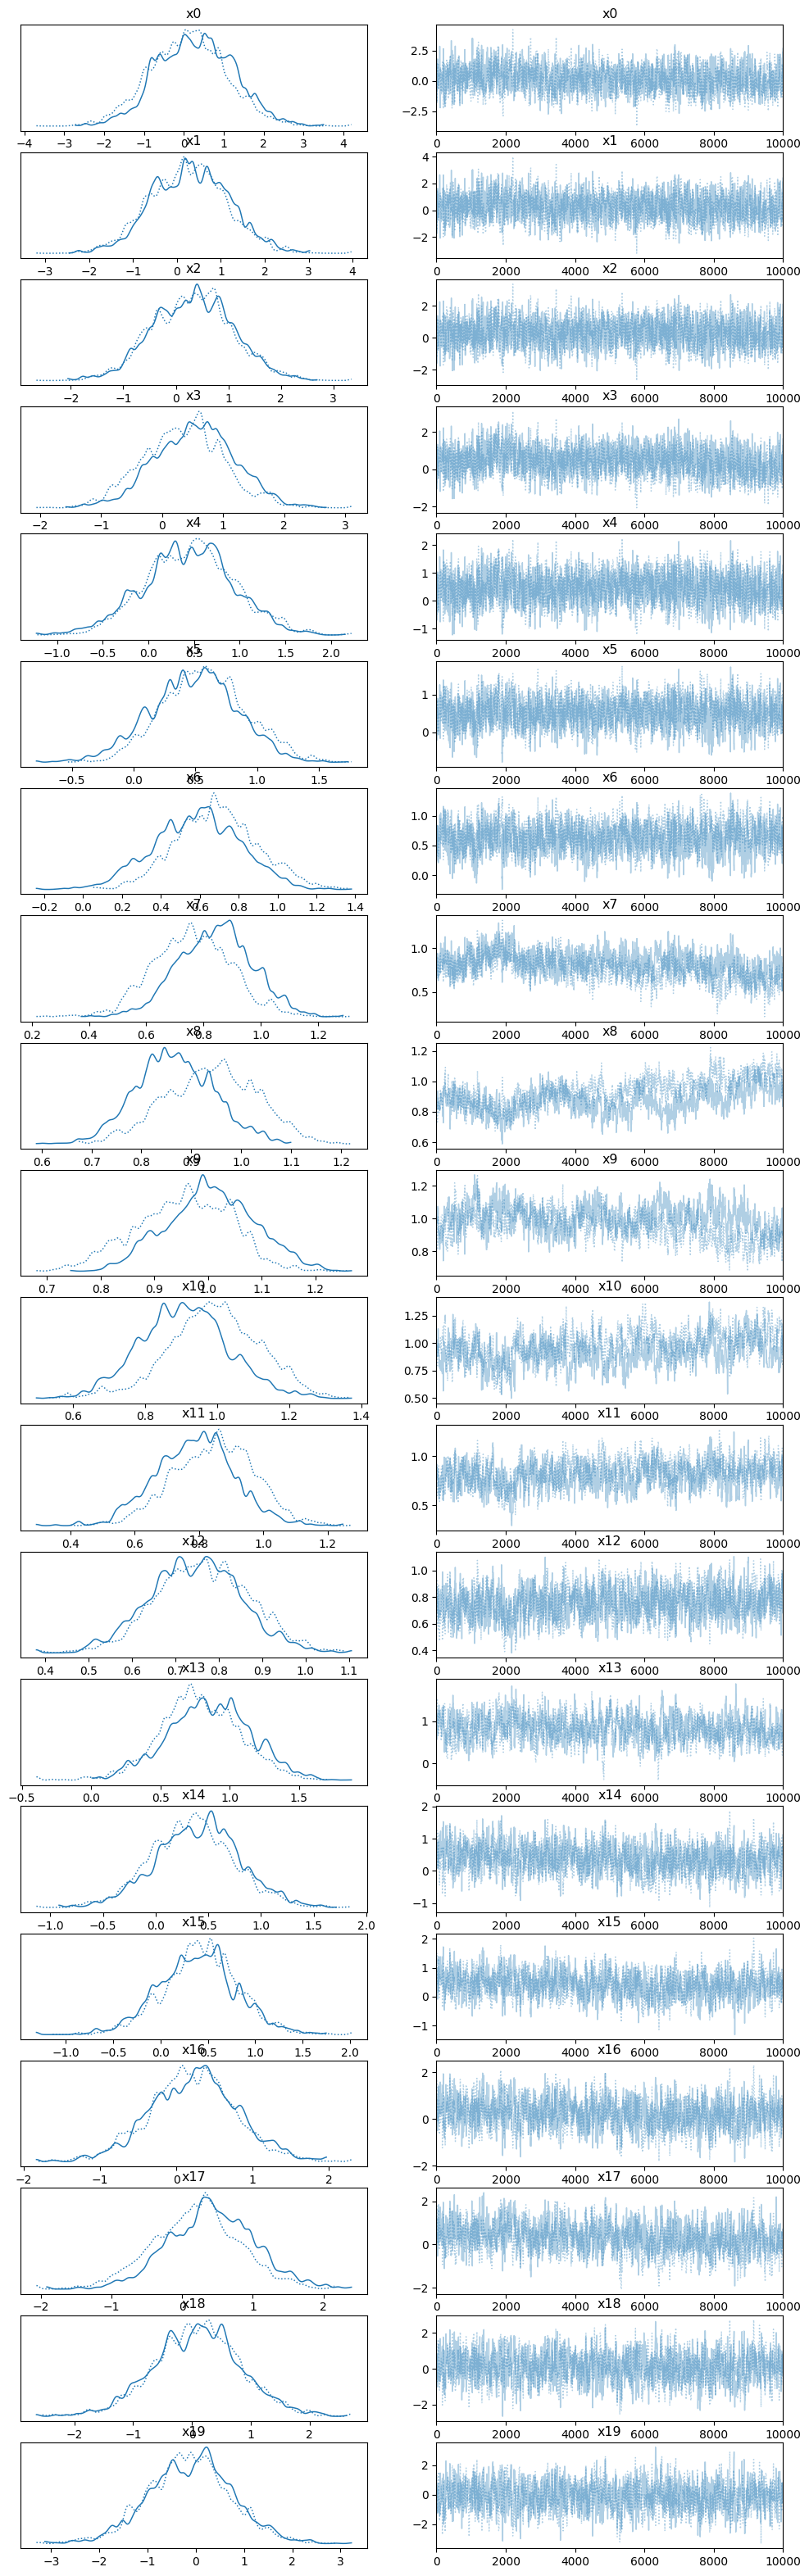

In [21]:
az.plot_trace(idata)
plt.show()

In [22]:
parameters = np.array([link.parameters for link in my_chains['chain_0'][burnin:] + my_chains['chain_1'][burnin:]])

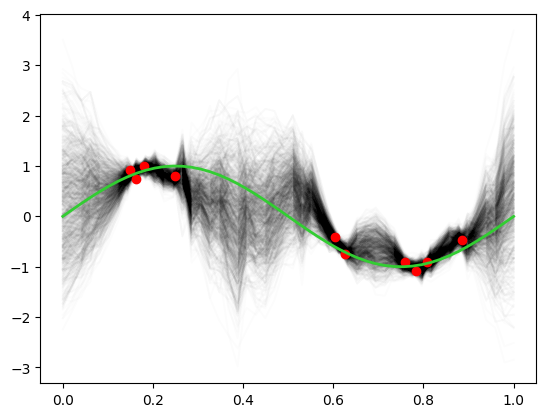

In [23]:
plt.plot(x, latent_function(x), c='limegreen', linewidth=2)
plt.scatter(x_data, y_data, c='r')
for i in range(1000):
    idx = np.random.randint(parameters.shape[0])
    plt.plot(x, parameters[idx,:], c='k', alpha=0.01, zorder=0)
plt.show()